In [35]:
import h5py

In [36]:
import numpy as np

In [37]:
import matplotlib as mpl
from matplotlib.colors import LogNorm

In [38]:
import matplotlib.pyplot as plt

In [39]:
%matplotlib inline

In [40]:
phad = '/home/pawel/Work/PIConGPU/151_PizDaintCopper30nmPerfectContrast/simOutput/h5/'

In [41]:
!ls $phad

simData_0.h5	   simData_137500.h5  simData_25000.h5	simData_65000.h5
simData_100000.h5  simData_140000.h5  simData_2500.h5	simData_67500.h5
simData_10000.h5   simData_142500.h5  simData_27500.h5	simData_70000.h5
simData_102500.h5  simData_145000.h5  simData_30000.h5	simData_72500.h5
simData_105000.h5  simData_147500.h5  simData_32500.h5	simData_75000.h5
simData_107500.h5  simData_150000.h5  simData_35000.h5	simData_7500.h5
simData_110000.h5  simData_15000.h5   simData_37500.h5	simData_77500.h5
simData_112500.h5  simData_152500.h5  simData_40000.h5	simData_80000.h5
simData_115000.h5  simData_155000.h5  simData_42500.h5	simData_82500.h5
simData_117500.h5  simData_157500.h5  simData_45000.h5	simData_85000.h5
simData_120000.h5  simData_160000.h5  simData_47500.h5	simData_87500.h5
simData_122500.h5  simData_162500.h5  simData_50000.h5	simData_90000.h5
simData_125000.h5  simData_165000.h5  simData_5000.h5	simData_92500.h5
simData_12500.h5   simData_167500.h5  simData_52500.h5	simData_95000.h

In [42]:
step = '40000'

In [43]:
f = h5py.File(phad + 'simData_'+step+'.h5')

In [44]:
print(list(f['/data/40000/fields']))

['B', 'C_chargeDensity', 'C_density', 'C_energyDensity', 'Cu_chargeDensity', 'Cu_density', 'Cu_energyDensity', 'E', 'H_chargeDensity', 'H_density', 'H_energyDensity', 'J', 'e_chargeDensity', 'e_density', 'e_energyDensity', 'ph_chargeDensity', 'ph_density', 'ph_energyDensity']


In [45]:
print(list(f['/data/'+step+'/fields']))

['B', 'C_chargeDensity', 'C_density', 'C_energyDensity', 'Cu_chargeDensity', 'Cu_density', 'Cu_energyDensity', 'E', 'H_chargeDensity', 'H_density', 'H_energyDensity', 'J', 'e_chargeDensity', 'e_density', 'e_energyDensity', 'ph_chargeDensity', 'ph_density', 'ph_energyDensity']


In [46]:
n_e_h5py = f['/data/'+step+'/fields/e_density']

In [47]:
n_e = n_e_h5py.value * n_e_h5py.attrs['unitSI']

In [52]:
np.max(n_e)

9.189403e+29

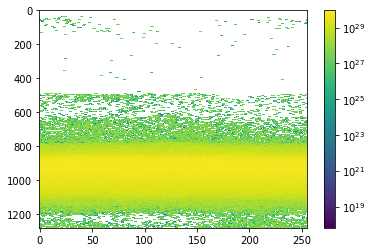

In [62]:
fig1, axis1 = plt.subplots(1)
plt.imshow(n_e, norm=LogNorm(), aspect='auto')
fig1.colorbar(axis1.images[0])

In [50]:
B_x_h5py = f['data/'+step+'/fields/B/x']
B_y_h5py = f['data/'+step+'/fields/B/y']
B_z_h5py = f['data/'+step+'/fields/B/z']

In [32]:
B_x = B_x_h5py.value * B_x_h5py.attrs['unitSI']
B_y = B_y_h5py.value * B_y_h5py.attrs['unitSI']
B_z = B_z_h5py.value * B_z_h5py.attrs['unitSI']

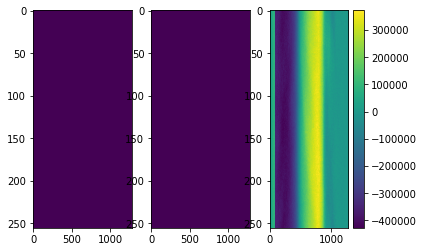

In [33]:
fig, axis = plt.subplots(1,3)
axis[0].imshow(B_x.T, aspect='auto')
axis[1].imshow(B_y.T, aspect='auto')
axis[2].imshow(B_z.T, aspect='auto')
fig.colorbar(axis[2].images[0])

In [34]:
path = '../Faraday_Rotation/test_samples/'

In [35]:
np.save(path + 'sim2.npy', B_z * n_e)

In [19]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


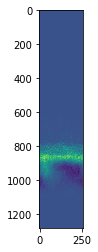

In [37]:
plt.imshow((B_z * n_e))


In [21]:
%matplotlib inline

In [22]:
%load_ext Cython

In [23]:
%%cython
cimport cython
cimport numpy as np
import  numpy as np
from libc.math cimport sqrt
from scipy.linalg.cython_blas cimport dgemv
#@cython.boundscheck(False)
#@cython.wraparound(False)

cdef int _rotation(double [:,::1] input_data, double [:,::1] output_data,
                  double [:] coeff):
    cdef Py_ssize_t r_len, s_len
    r_len = input_data.shape[1]
    s_len = input_data.shape[0]
    cdef Py_ssize_t r_len_down, r_len_up, r_start_up, r_start_down, loop_start
    cdef bint input_is_odd 
    if r_len%2 ==0:
        input_is_odd = False
        r_len_down = r_len//2
        r_len_up = r_len_down
        r_start_up = r_len_down 
        r_start_down = 0
        loop_start = 0
    else:
        input_is_odd = True
        #include 0th line (middle) in the down part.
        r_len_down = r_len // 2 + 1 # floor division
        r_len_up = r_len // 2
        r_start_up = r_len_down 
        r_start_down = 0 
        loop_start = 1
    cdef Py_ssize_t yy, ii

    cdef char* trans = 't'
    cdef int n = s_len
    cdef Py_ssize_t  mm
    cdef int m
    cdef int lda = r_len
    cdef double alpha = 1
    cdef double beta = 0
    cdef int incy = 1
    cdef int incx_up = 1
    cdef int incx_down = 1
    cdef double* A_start_up
    cdef double* A_start_down
    cdef double* output_start_up
    cdef double* output_start_down
    cdef double* coeff_start_up = &coeff[0]
    cdef double* coeff_start_down
    cdef double val
    for yy in range(loop_start, r_len_up):
        mm = r_len_up - yy
        coeff_start_down = &coeff[mm]
        for ii in range (mm):
            val = (sqrt((yy + ii + 0.5)**2 - yy**2))**(-1)
            coeff[2*mm-1-ii] = val 
            coeff[ii] = val
        #
        m = mm
        A_start_up = &input_data[0,r_start_up + yy]
        A_start_down = &input_data[0,r_start_down]
        output_start_down = &output_data[r_len - r_len_up+ yy,0]
        output_start_up = &output_data[yy,0]
        dgemv(trans, &m, &n, &alpha, A_start_up, &lda, coeff_start_up,
                         &incx_up, &beta, output_start_up, &incy)
        dgemv(trans, &m, &n, &alpha, A_start_down, &lda, coeff_start_down,
                        &incx_down , &beta, output_start_down, &incy)
    if input_is_odd:
        #calculate the middle line
        m = r_len_down
        for ii in range (m):
            coeff[ii] = (sqrt(ii + 0.5)**2)**(-1)
        A_start_down = &input_data[r_len_down,0]
        output_start_down = &input_data[r_len_down,0]

        dgemv(trans, &m, &n, &alpha, A_start_down, &lda, coeff_start_down,
                         &incx_down, &beta, output_start_down, &incy)   
    return 0

def rotation(input_data):
    try:
        input_data.flags
    except AttributeError:
        print('input_data should be a numpy array!')
        raise
    if input_data.flags['F_CONTIGUOUS']:
        print('input_data should be stored in a raw major, C contigous.')
    elif not input_data.flags['C_CONTIGUOUS']:
        print('input_data as to be a contigous array.')
    
    output = np.zeros(input_data.size, dtype=np.float64, order='C').reshape(
                    input_data.shape[1], input_data.shape[0])
    # coeff hast the length of the half of the distribution;
    # +1 for the odd case (odd number of columns).
    coeff = np.empty(input_data.shape[1], dtype=np.float64, order='C')
    
    cdef double [:,::1] input_data_view = input_data
    cdef double [:,::1] output_view = output
    cdef double [:] coeff_view = coeff
    _rotation(input_data_view, output_view, coeff_view)
    return output

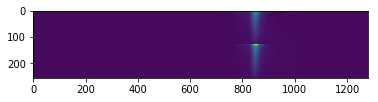

In [24]:
plt.imshow(rotation(n_e * B_z.astype(np.float64)))

In [ ]:
%matplotlib auto 

In [ ]:
B_z.nonzero()

In [ ]:
J_x_h5py = f['data/15/fields/J/x']
J_y_h5py = f['data/15/fields/J/y']
J_z_h5py = f['data/15/fields/J/z']

In [ ]:
J_x = J_x_h5py.value * J_x_h5py.attrs['unitSI']
J_y = J_y_h5py.value * J_y_h5py.attrs['unitSI']
J_z = J_z_h5py.value * J_z_h5py.attrs['unitSI']

In [ ]:
fig, axis = plt.subplots(1,2, figsize=(15,8))
axis[0].imshow(J_x, norm=LogNorm(), aspect='auto')
axis[1].imshow(J_y, norm=LogNorm(), aspect='auto')
fig.colorbar(axis[0].images[0], ax=axis[0])
fig.colorbar(axis[1].images[0], ax=axis[1])

Laser propagation in y direction (?)


In [ ]:
list(J_x_h5py.attrs)

In [ ]:
J_x_h5py.attrs['_global_size']

In [ ]:
list(f['data/5000/fields'])

In [ ]:
list(f['data/'])